In [1]:
import os, sys, urllib, gzip
import cPickle as pickle
sys.setrecursionlimit(10000)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image

In [3]:
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


In [4]:
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
    print 'Using cuda_convnet (faster)'
except ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
    print 'Using lasagne.layers (slower)'

Using cuda_convnet (faster)


In [5]:
fname = 'mnist/mnist.pkl.gz'
if not os.path.isfile(fname):
    testfile = urllib.URLopener()
    testfile.retrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", fname)
f = gzip.open(fname, 'rb')
train_set, valid_set, test_set = pickle.load(f)
f.close()
X, y = train_set

In [6]:
# reshape from (50000, 784) to 4D tensor (50000, 1, 28, 28)
X = np.reshape(X, (-1, 1, 28, 28))
print 'X type and shape:', X.dtype, X.shape
print 'X.min():', X.min()
print 'X.max():', X.max()

X type and shape: float32 (50000, 1, 28, 28)
X.min(): 0.0
X.max(): 0.996094


In [7]:
# we need our target to be 1 dimensional
X_out = X.reshape((X.shape[0], -1))
print 'X_out:', X_out.dtype, X_out.shape

X_out: float32 (50000, 784)


In [8]:
conv_num_filters = 16
filter_size = 3
pool_size = 2
epochs = 20
encode_size = 16
dense_mid_size = 128
layers = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}), 
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': 'same'}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': 'same'}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': 'same'}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (ReshapeLayer, {'shape': (([0], -1))}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'name': 'encode', 'num_units': encode_size}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'num_units': 784}),
    (ReshapeLayer, {'shape': (([0], 16, 7, 7))}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': 'same'}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerSlow, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': 'same'}),
    (Conv2DLayerSlow, {'num_filters': 1, 'filter_size': filter_size, 'pad': 'same'}),
    (ReshapeLayer, {'shape': (([0], -1))}),
]

In [9]:
ae = NeuralNet(
    layers=layers,
    max_epochs=epochs,
    
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.975,
    
    regression=True,
    verbose=1
)
# ae.initialize()
# PrintLayerInfo()(ae)

In [10]:
ae.fit(X, X_out)

# Neural Network with 215441 learnable parameters

## Layer information

  #  name          size
---  ------------  --------
  0  input0        1x28x28
  1  conv2dcc1     16x28x28
  2  conv2dcc2     16x28x28
  3  maxpool2dcc3  16x14x14
  4  conv2dcc4     16x14x14
  5  maxpool2dcc5  16x7x7
  6  reshape6      784
  7  dense7        128
  8  encode        16
  9  dense9        128
 10  dense10       784
 11  reshape11     16x7x7
 12  upscale2d12   16x14x14
 13  conv2dcc13    16x14x14
 14  upscale2d14   16x28x28
 15  conv2d15      16x28x28
 16  conv2d16      1x28x28
 17  reshape17     784

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.07649       0.05805      1.31749  7.34s
      2       0.04833       0.04017      1.20298  7.30s
      3       0.03597       0.03240      1.11029  7.27s
      4       0.03095       0.02913      1.06242  7.32s
      5       0.02848       0.02718      1.04799  7.35s
      6       0.0

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fe815aba0d0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7fe815aba050>,
     custom_score=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 28, 28)}), (<class 'lasagne.layers.cuda_convnet.Conv2DCCLayer'>, {'filter_size': 3, 'pad': 'same', 'num_filters': 16}), (<class 'lasagne.layers.cuda_convnet.Conv2DCCLayer'>, {'filter_size': 3, 'pad': 'same', 'num_filters': 16}),...d': 'same', 'num_filters': 1}), (<class 'lasagne.layers.shape.ReshapeLayer'>, {'shape': ([0], -1)})],
     loss=None, max_epochs=20, more_params={},
     objective=<function objective at 0x7fe815ab8c80>,
     objective_loss_function=<function squared_error at 0x7fe817301230>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7fe815ae65a8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInf

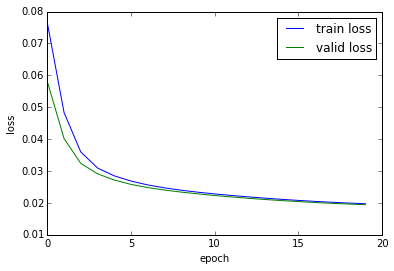

In [11]:
from nolearn.lasagne.visualize import plot_loss
plot_loss(ae)

In [12]:
# ae.save_params_to('mnist/conv_ae.np')
pickle.dump(ae, open('mnist/conv_ae.pkl','w'))
# ae = pickle.load(open('mnist/conv_ae.pkl','r'))
# ae.layers

In [13]:
X_pred = ae.predict(X).reshape(-1, 28, 28)
X_pred = np.rint(256. * X_pred).astype(int)
X_pred = np.clip(X_pred, a_min = 0, a_max = 255)
X_pred = X_pred.astype('uint8')
print X_pred.shape , X.shape

(50000, 28, 28) (50000, 1, 28, 28)


In [14]:
!mkdir -p data
!mkdir -p montage

2


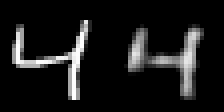

In [53]:
###  show random inputs / outputs side by side

def get_picture_array(X, rescale=4):
    array = X.reshape(28,28)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

def compare_images(index):
    print index
    original_image = Image.fromarray(get_picture_array(255 * X[index]))
    new_size = (original_image.size[0] * 2, original_image.size[1])
    new_im = Image.new('L', new_size)
    new_im.paste(original_image, (0,0))
    rec_image = Image.fromarray(get_picture_array(X_pred[index]))
    new_im.paste(rec_image, (original_image.size[0],0))
    new_im.save('data/test.png', format="PNG")
    return IPImage('data/test.png')

compare_images(2)
# compare_images(np.random.randint(50000))

In [28]:
## we find the encode layer from our ae, and use it to define an encoding function

def get_layer_by_name(net, name):
    for i, layer in enumerate(net.get_all_layers()):
        if layer.name == name:
            return layer, i
    return None, None
encode_layer, encode_layer_index = get_layer_by_name(ae, 'encode')

def get_output_from_nn(last_layer, X, batch_size=128):
    indices = np.arange(batch_size, X.shape[0], batch_size)
    X_batches = np.split(X, indices)
    out = []
    for X_batch in X_batches:
        out.append(get_output(last_layer, inputs=X_batch).eval())
    return np.vstack(out)

def encode_input(X):
    return get_output_from_nn(encode_layer, X)

X_encoded = encode_input(X)

In [34]:
next_layer = ae.get_all_layers()[encode_layer_index + 1]
final_layer = ae.get_all_layers()[-1]
new_layer = InputLayer(shape=(None, encode_layer.num_units))

# N.B after we do this, we won't be able to use the original autoencoder , as the layers are broken up
next_layer.input_layer = new_layer

(1, 784)


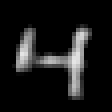

In [54]:
def decode_encoded_input(X):
    return get_output_from_nn(final_layer, X)

X_decoded = 256 * decode_encoded_input(X_encoded[2])

X_decoded = np.rint(X_decoded).astype(int)
X_decoded = np.clip(X_decoded, a_min = 0, a_max = 255)
X_decoded  = X_decoded.astype('uint8')
print X_decoded.shape

pic_array = get_picture_array(X_decoded)
image = Image.fromarray(pic_array)
image.save('data/test.png', format="PNG")  
IPImage('data/test.png')

In [55]:
enc_std = X_encoded.std(axis=0)
enc_mean = X_encoded.mean(axis=0)
enc_min = X_encoded.min(axis=0)
enc_max = X_encoded.max(axis=0)
m = X_encoded.shape[1]

In [58]:
n = 256
generated = np.random.normal(0, 1, (n, m)) * enc_std + enc_mean
generated = generated.astype(np.float32).clip(enc_min, enc_max)
X_decoded = decode_encoded_input(generated) * 256.
X_decoded = np.rint(X_decoded ).astype(int)
X_decoded = np.clip(X_decoded, a_min = 0, a_max = 255)
X_decoded  = X_decoded.astype('uint8')
!mkdir -p montage
for i in range(n):
    pic_array = get_picture_array(X_decoded[i], rescale=1)
    image = Image.fromarray(pic_array)
    image.save('montage/{0:03d}.png'.format(i), format='png')

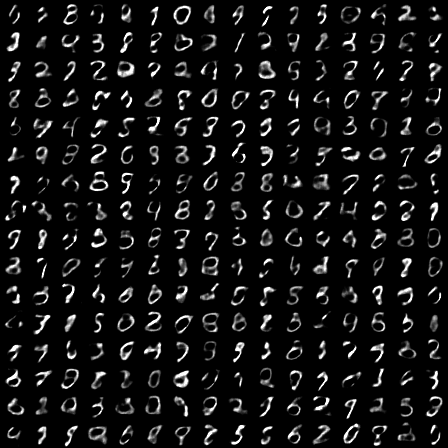

In [59]:
!montage -mode concatenate -tile 16x montage/*.png montage.png
IPImage('montage.png')